In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool
import warnings
warnings.filterwarnings('ignore')

In [34]:
df = pd.read_excel('datasets/FinalDataset.xlsx')

In [35]:
df['is_scam'] = (df['from_scam'] == 1) | (df['to_scam'] == 1)
df['is_scam'] = df['is_scam'].astype(int)

transaction_features = [
    'value',
    'gas',
    'gas_price',
    'receipt_gas_used',
]

df['block_timestamp'] = pd.to_datetime(df['block_timestamp'], format='mixed', utc=True)
df['tx_hour'] = df['block_timestamp'].dt.hour
df['tx_day_of_week'] = df['block_timestamp'].dt.dayofweek
df['is_weekend'] = (df['tx_day_of_week'] >= 5).astype(int)

time_features = ['tx_hour', 'tx_day_of_week', 'is_weekend']

all_features = transaction_features + time_features

In [36]:
df['gas_used_ratio'] = df['receipt_gas_used'] / df['gas']
df['gas_used_ratio'] = df['gas_used_ratio'].replace([np.inf, -np.inf], 1.0)
df['gas_used_ratio'] = df['gas_used_ratio'].fillna(1.0)
all_features.append('gas_used_ratio')

In [37]:
all_features

['value',
 'gas',
 'gas_price',
 'receipt_gas_used',
 'tx_hour',
 'tx_day_of_week',
 'is_weekend',
 'gas_used_ratio']

In [38]:
X = df[all_features]
y = df['is_scam']

# Стратифицированное разделение 70/15/15
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp  # 0.1765 * 0.85 ≈ 0.15
)

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Обучение

In [40]:
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

params = {
    'iterations': 500,
    'learning_rate': 0.05,
    'depth': 6,
    'l2_leaf_reg': 3,
    'random_seed': 42,
    'verbose': 100,
    'early_stopping_rounds': 50,
    'eval_metric': 'F1',
    'loss_function': 'Logloss',
    'auto_class_weights': 'Balanced',
    'use_best_model': True
}

model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=val_pool)

0:	learn: 0.7126046	test: 0.7055130	best: 0.7055130 (0)	total: 10.1ms	remaining: 5.04s
100:	learn: 0.8563912	test: 0.8575318	best: 0.8575318 (100)	total: 435ms	remaining: 1.72s
200:	learn: 0.8809905	test: 0.8808875	best: 0.8809454 (196)	total: 854ms	remaining: 1.27s
300:	learn: 0.8996477	test: 0.8966699	best: 0.8968323 (295)	total: 1.28s	remaining: 848ms
400:	learn: 0.9099146	test: 0.9051444	best: 0.9051444 (400)	total: 1.72s	remaining: 425ms
499:	learn: 0.9173118	test: 0.9107425	best: 0.9108520 (490)	total: 2.13s	remaining: 0us

bestTest = 0.9108520093
bestIteration = 490

Shrink model to first 491 iterations.


Оценка на валидации

In [41]:
val_pred = model.predict(X_val)
val_pred_proba = model.predict_proba(X_val)[:, 1]

print("\nКлассификационный отчет (валидация):")
print(classification_report(y_val, val_pred, target_names=['Нормальные', 'Аномальные']))

val_cm = confusion_matrix(y_val, val_pred)
print("Матрица ошибок (валидация):")
cm_df = pd.DataFrame(val_cm, 
                     index=['Факт: Норма', 'Факт: Аномалия'], 
                     columns=['Прогноз: Норма', 'Прогноз: Аномалия'])
print(cm_df)

val_roc_auc = roc_auc_score(y_val, val_pred_proba)
val_f1 = f1_score(y_val, val_pred)
print(f"\nROC-AUC на валидации: {val_roc_auc:.4f}")
print(f"F1-Score на валидации: {val_f1:.4f}")


Классификационный отчет (валидация):
              precision    recall  f1-score   support

  Нормальные       0.97      0.94      0.96      8552
  Аномальные       0.79      0.89      0.83      2138

    accuracy                           0.93     10690
   macro avg       0.88      0.91      0.89     10690
weighted avg       0.93      0.93      0.93     10690

Матрица ошибок (валидация):
                Прогноз: Норма  Прогноз: Аномалия
Факт: Норма               8045                507
Факт: Аномалия             244               1894

ROC-AUC на валидации: 0.9736
F1-Score на валидации: 0.8345


Важность признаков

In [42]:
feature_importance = model.get_feature_importance()
importance_df = pd.DataFrame({
    'Признак': X_train.columns,
    'Важность': feature_importance
}).sort_values('Важность', ascending=False)

print("\nТоп-10 самых важных признаков:")
print(importance_df.head(10).to_string(index=False))


Топ-10 самых важных признаков:
         Признак  Важность
           value 26.418803
       gas_price 24.757329
receipt_gas_used 20.667968
             gas 10.342712
  gas_used_ratio  8.985448
  tx_day_of_week  5.475151
         tx_hour  2.660952
      is_weekend  0.691636


Визуализация

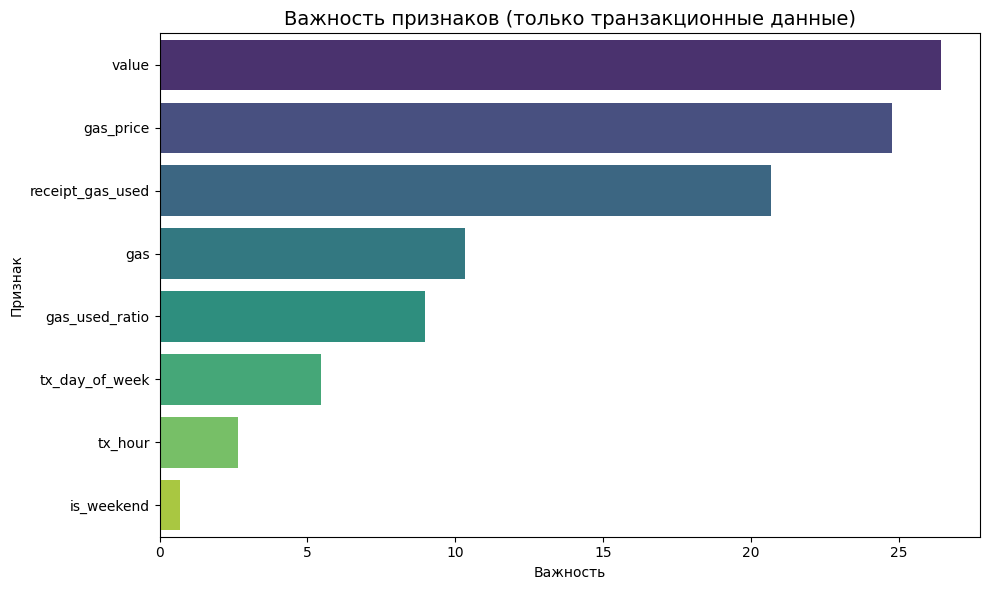

In [43]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Важность', y='Признак', data=importance_df.head(10), palette='viridis')
plt.title('Важность признаков (только транзакционные данные)', fontsize=14)
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

Оценка на тесте

In [44]:
test_pred = model.predict(X_test)
test_pred_proba = model.predict_proba(X_test)[:, 1]

print("\nКлассификационный отчет:")
print(classification_report(y_test, test_pred, target_names=['Нормальные', 'Аномальные']))


Классификационный отчет:
              precision    recall  f1-score   support

  Нормальные       0.97      0.94      0.96      8550
  Аномальные       0.79      0.89      0.84      2138

    accuracy                           0.93     10688
   macro avg       0.88      0.92      0.90     10688
weighted avg       0.94      0.93      0.93     10688



In [45]:
test_cm = confusion_matrix(y_test, test_pred)
print("Матрица ошибок (тест):")
test_cm_df = pd.DataFrame(test_cm, 
                         index=['Факт: Норма', 'Факт: Аномалия'], 
                         columns=['Прогноз: Норма', 'Прогноз: Аномалия'])
test_cm_df

Матрица ошибок (тест):


,Прогноз: Норма,Прогноз: Аномалия
Факт: Норма,8040,510
Факт: Аномалия,230,1908


In [ ]:
test_roc_auc = roc_auc_score(y_test, test_pred_proba)
test_f1 = f1_score(y_test, test_pred)
test_precision = test_cm[1,1] / (test_cm[0,1] + test_cm[1,1]) if (test_cm[0,1] + test_cm[1,1]) > 0 else 0
test_recall = test_cm[1,1] / (test_cm[1,0] + test_cm[1,1]) if (test_cm[1,0] + test_cm[1,1]) > 0 else 0

print(f"\nИтоговые метрики на тесте:")
print(f"  • ROC-AUC: {test_roc_auc:.4f}")
print(f"  • F1-Score: {test_f1:.4f}")
print(f"  • Precision: {test_precision:.4f}")
print(f"  • Recall: {test_recall:.4f}")


Итоговые метрики на тесте:
  • ROC-AUC: 0.9725
  • F1-Score: 0.8376
  • Precision: 0.7891
  • Recall: 0.8924
